In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys

# Non pythonic hack to reuse some utility code
if sys.path[0] != '../py_utils':
    sys.path.insert(0,'../py_utils')

import utils
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import log_loss
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from pathlib import Path
%matplotlib inline
pd.set_option('display.max_columns', 500)
print("Seaborn version: ", sns.__version__)

Seaborn version:  0.9.0


In [67]:
def eliminate_features_logistic_regression(classifier, X, y ):
    iteration = 0
    print("Iteration= ", iteration)
    iteration += 1
    model_stats = {}
    drop_list = []
    # get baseline by identifying sorted important features using all of the provided features
    model_stats = utils.save_model_stats(classifier,X,y,model_stats)
    important_features = utils.display_important_features(classifier.coef_[0], X,0)
    #important_features = display_important_features_regression(classifier, X,0)
    # least important feature
    least_important_label = important_features[-1][0]
    print("least_important label= ", least_important_label)
    
    drop_list.append(least_important_label)
    del important_features[-1]
    
    # drop list contains all of the feature labels except for the feature label identified as being most important
    list_count = len(important_features)
    while list_count > 0:
        print("Iteration= ", iteration)
        iteration += 1
        model_stats = utils.save_model_stats(classifier,X.drop(columns=drop_list),y,model_stats)
        least_important_label = important_features[-1][0]
        print("least_important label= ", least_important_label)
        drop_list.append(least_important_label)
        del important_features[-1]
        list_count-=1
    return model_stats

#### Power Conference Feature

From EDA we know that a small number of conferences account for 70% of all conference wins. 

If one of the two teams is in a power conference, indicate the advantage that team has for winning the game.

#### Read in regular season team statistics from SRCBB https://www.sports-reference.com/cbb/

In [3]:
summary_data = pd.read_csv(Path( '../Data/sr_summaries_kaggle_id.csv'))
print(summary_data.shape)

#display rows with NaNs
summary_data[summary_data.isnull().any(axis=1)]


(2773, 22)


,season,School,team_id,Games,SRS,SOS,win_pct,pts_avg,opp_pts_avg,fg_pct,allow_fg_pct,ft_pct,allow_ft_att_avg,poss_avg,off_rebs_avg,allow_off_rebs_avg,def_rebs_avg,allow_def_rebs_avg,to_avg,steal_avg,off_rating,ft_att_avg
38,2009,Centenary (LA),NaN,29,-17.16,-5.08,0.276,70,80,0.416,0.49,0.733,25,80.641379,9,11,20,27,15,7,86.804071,21


In [4]:
#drop records with NaNs
summary_data.dropna(inplace=True)
print(summary_data.shape)


(2772, 22)


#### Read table of team names and associated team meta data from the Kaggle data set.
https://console.cloud.google.com/bigquery?project=bigqueryncaa&p=bigquery-public-data&d=ncaa_basketball&page=dataset

In [5]:
# Read table of team names and associated team meta data
teams = pd.read_csv(Path('../Data/D1_teams.csv'))
teams.drop(columns=['code_ncaa','school_ncaa','turner_name','league_name','league_alias','conf_alias',
                    'conf_id','division_name','division_alias','division_id',
                    'kaggle_team_id','venue_id'], inplace=True)
teams.info()
teams.set_index('id',inplace=True)
teams.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 2 columns):
id           351 non-null object
conf_name    351 non-null object
dtypes: object(2)
memory usage: 5.6+ KB


,conf_name
id,
fe406882-9f22-495e-9df6-ef357a6803c6,Ivy
ca478771-aa3d-4231-81e0-b70f519134fb,Ivy
5c7bf63f-bc39-43c5-9907-73b50b7a6b34,Ivy
d60357bd-1205-42e9-9092-d986a2843a34,Ivy
88ff8c00-958e-4ccf-a21d-77fab9e93692,Ivy


#### Read in the NCAA Men's Tournament results from the the Kaggle data set.

In [6]:
tourney_data = pd.read_csv(Path('../Data/tournament_results.csv'))
tourney_data.drop(columns=['days_from_epoch','day','num_ot','academic_year','win_region','win_alias','lose_region',
                           'lose_alias','lose_code_ncaa','win_school_ncaa','win_code_ncaa','win_name','lose_name',
                           'win_pts','win_kaggle_team_id','lose_school_ncaa','lose_kaggle_team_id','lose_pts'],inplace=True)

tourney_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2117 entries, 0 to 2116
Data columns (total 9 columns):
season          2117 non-null int64
round           2117 non-null int64
game_date       2117 non-null object
win_seed        2117 non-null int64
win_market      2117 non-null object
win_team_id     2117 non-null object
lose_seed       2117 non-null int64
lose_market     2117 non-null object
lose_team_id    2117 non-null object
dtypes: int64(4), object(5)
memory usage: 148.9+ KB


In [7]:
game_data = tourney_data.join(teams, on='win_team_id',how='left')
game_data.rename(columns={'kaggle_team_id':'win_kaggle_team_id','conf_name':'win_conf_name'}, inplace=True)
game_data = game_data.join(teams,on='lose_team_id',how='left')
game_data.rename(columns={'kaggle_team_id':'lose_kaggle_team_id','conf_name':'lose_conf_name'}, inplace=True)
games_won_conf = game_data.groupby('win_conf_name').size().reset_index(name='count').sort_values(by=['count'], ascending=False)

games_won_conf['percent'] = 100 * games_won_conf['count']/games_won_conf['count'].sum()
games_won_conf['cum_percent'] = games_won_conf['percent'].cumsum()
games_won_conf.head()

,win_conf_name,count,percent,cum_percent
3,Atlantic Coast,431,20.358999,20.358999
9,Big Ten,313,14.785073,35.144072
24,Southeastern,269,12.706660,47.850732
5,Big 12,231,10.911667,58.762400
22,Pacific 12,197,9.305621,68.068021


Identify the conferences that have won 70% of all conference games

In [8]:
top_tournament_conferences_list = games_won_conf[games_won_conf['cum_percent']<= 70]['win_conf_name'].tolist()
top_tournament_conferences_list

['Atlantic Coast', 'Big Ten', 'Southeastern', 'Big 12', 'Pacific 12']

The summary season data is available from 2010 through 2017.

So the intersection of season summary data with tournament data are seasons 2010-2017.

In [9]:
tourney_data = tourney_data[tourney_data['season'] >= 2010]
tourney_data.describe()['season']

count     533.000000
mean     2013.519700
std         2.284733
min      2010.000000
25%      2012.000000
50%      2014.000000
75%      2016.000000
max      2017.000000
Name: season, dtype: float64

In [10]:
# recode the tourney data so that the teams are not marked with  win/lose status and the game result is encoded as a binary
tourney_data['game_result'] = 1
tourney_data.game_result = tourney_data.game_result.astype(int)
tourney_data.rename(columns={"win_seed":"team_seed","win_market":"team","win_team_id":"team_id"}, inplace=True)
tourney_data.rename(columns={"lose_seed":"opp_team_seed","lose_market":"opp_team","lose_team_id":"opp_team_id"}, inplace=True)
tourney_data['start_season'] = tourney_data['season'] -1

#create some temporary buffer columns
tourney_data['copy_team'] = tourney_data['team']
tourney_data['copy_team_seed'] = tourney_data['team_seed']
tourney_data['copy_team_id'] = tourney_data['team_id']

#swap the team and opp team data
tourney_data.loc[1::2,'team'] = tourney_data.loc[1::2,'opp_team']
tourney_data.loc[1::2,'opp_team'] = tourney_data.loc[1::2,'copy_team']
tourney_data.loc[1::2,'team_seed'] = tourney_data.loc[1::2,'opp_team_seed']
tourney_data.loc[1::2,'opp_team_seed'] = tourney_data.loc[1::2,'copy_team_seed']
tourney_data.loc[1::2,'team_id'] = tourney_data.loc[1::2,'opp_team_id']
tourney_data.loc[1::2,'opp_team_id'] = tourney_data.loc[1::2,'copy_team_id']

# flip the game result
tourney_data.loc[1::2,'game_result'] = 0

#drop the temporary columns
tourney_data.drop(columns=['copy_team','copy_team_seed','copy_team_id'],inplace=True)
tourney_data.rename(columns={"team_seed":"seed_t","opp_team_seed":"seed_o"}, inplace=True)

tourney_data['Game Result'] = tourney_data.game_result.map({1:'Win', 0:'Lose'})
tourney_data = tourney_data.merge(summary_data, left_on=['start_season','team_id'], 
                                right_on=['season', 'team_id'],how='left',suffixes=('','_y'))

tourney_data.drop(columns=['season_y'],inplace=True)
tourney_data = tourney_data.merge(summary_data, left_on=['start_season','opp_team_id'], 
                                right_on=['season', 'team_id'], how='left',suffixes=('_t','_o'))

tourney_data.drop(columns=['School_t','School_o','Games_t','Games_o','team_id_o'],inplace=True)

tourney_data = tourney_data.join(teams, on='team_id_t', how='left')
tourney_data = tourney_data.join(teams, on='opp_team_id', how='left', lsuffix='_t', rsuffix='_o')
tourney_data.rename(index=str,columns={'team':'team_t','opp_team':'team_o', 'opp_team_id':'team_id_o'},inplace=True)

tourney_data['game_result'] = tourney_data.game_result.apply(utils.negate_loser)
tourney_data.head()



,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,game_result,start_season,Game Result,SRS_t,SOS_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,allow_fg_pct_t,ft_pct_t,allow_ft_att_avg_t,poss_avg_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,SRS_o,SOS_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,allow_fg_pct_o,ft_pct_o,allow_ft_att_avg_o,poss_avg_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o
0,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,-1,2012,Lose,14.32,7.17,0.686,77,70,0.496,0.419,0.681,17,78.434286,11,12,22,21,12,6,98.171354,23,2012,9.52,5.20,0.706,72,67,0.428,0.438,0.723,18,77.494118,11,10,19,25,10,7,92.910278,20,Atlantic Coast,American Athletic
1,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,1,2010,Win,12.35,4.23,0.765,70,62,0.447,0.435,0.698,19,75.688235,11,11,24,22,10,6,92.484651,19,2010,11.98,11.45,0.559,63,62,0.439,0.434,0.724,21,68.341176,9,8,21,23,10,4,92.184541,16,American Athletic,Big Ten
2,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,-1,2012,Lose,8.11,0.18,0.788,71,62,0.455,0.395,0.643,19,78.884848,12,10,21,21,13,7,90.004610,20,2012,16.89,4.47,0.750,76,64,0.450,0.444,0.701,20,81.044444,13,11,18,23,11,11,93.775706,18,Mid-American,Atlantic 10
3,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,1,2011,Win,8.79,0.63,0.806,68,59,0.410,0.424,0.685,18,76.305556,12,10,18,24,11,10,89.115399,20,2011,17.42,3.80,0.818,77,62,0.482,0.393,0.748,18,77.496970,10,9,24,21,12,6,99.358724,19,Atlantic 10,American Athletic
4,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,-1,2010,Lose,24.10,7.62,0.921,81,64,0.508,0.380,0.679,18,80.126316,11,10,27,21,13,7,101.090384,22,2010,8.56,3.78,0.700,71,66,0.434,0.424,0.715,18,75.240000,10,10,21,24,11,8,94.364700,20,Big 12,Atlantic 10


In [11]:
computer_rankings = pd.read_csv(Path( '../Data/massey_seasons_with_id.csv'))
computer_rankings = computer_rankings[computer_rankings['season']>=2010]
computer_rankings[computer_rankings.isnull().any(axis=1)]

,SAG,WLK,WOL,Team,RTH,COL,POM,DOL,RPI,MOR,season,win_pct,kaggle_id


In [12]:
temp_merge = tourney_data.merge(computer_rankings, left_on=['season_t','team_id_t'], 
                                right_on=['season', 'kaggle_id'],how='left',suffixes=('','_y'))
temp_merge.drop(columns=['Team','season','win_pct','kaggle_id'],inplace=True)
temp_merge.head()

,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,game_result,start_season,Game Result,SRS_t,SOS_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,allow_fg_pct_t,ft_pct_t,allow_ft_att_avg_t,poss_avg_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,SRS_o,SOS_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,allow_fg_pct_o,ft_pct_o,allow_ft_att_avg_o,poss_avg_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,SAG,WLK,WOL,RTH,COL,POM,DOL,RPI,MOR
0,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,-1,2012,Lose,14.32,7.17,0.686,77,70,0.496,0.419,0.681,17,78.434286,11,12,22,21,12,6,98.171354,23,2012,9.52,5.20,0.706,72,67,0.428,0.438,0.723,18,77.494118,11,10,19,25,10,7,92.910278,20,Atlantic Coast,American Athletic,25,27.0,36,28,32.0,35.0,32.0,33.0,24
1,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,1,2010,Win,12.35,4.23,0.765,70,62,0.447,0.435,0.698,19,75.688235,11,11,24,22,10,6,92.484651,19,2010,11.98,11.45,0.559,63,62,0.439,0.434,0.724,21,68.341176,9,8,21,23,10,4,92.184541,16,American Athletic,Big Ten,32,30.0,25,32,27.0,38.0,25.0,30.0,45
2,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,-1,2012,Lose,8.11,0.18,0.788,71,62,0.455,0.395,0.643,19,78.884848,12,10,21,21,13,7,90.004610,20,2012,16.89,4.47,0.750,76,64,0.450,0.444,0.701,20,81.044444,13,11,18,23,11,11,93.775706,18,Mid-American,Atlantic 10,62,55.0,52,59,50.0,54.0,46.0,42.0,60
3,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,1,2011,Win,8.79,0.63,0.806,68,59,0.410,0.424,0.685,18,76.305556,12,10,18,24,11,10,89.115399,20,2011,17.42,3.80,0.818,77,62,0.482,0.393,0.748,18,77.496970,10,9,24,21,12,6,99.358724,19,Atlantic 10,American Athletic,50,43.0,32,54,35.0,47.0,33.0,38.0,55
4,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,-1,2010,Lose,24.10,7.62,0.921,81,64,0.508,0.380,0.679,18,80.126316,11,10,27,21,13,7,101.090384,22,2010,8.56,3.78,0.700,71,66,0.434,0.424,0.715,18,75.240000,10,10,21,24,11,8,94.364700,20,Big 12,Atlantic 10,2,2.0,3,2,1.0,3.0,2.0,1.0,3


In [13]:
tourney_comp_ratings = temp_merge.merge(computer_rankings,left_on=['season_t','team_id_o'], 
                                right_on=['season', 'kaggle_id'], how='left',suffixes=('_t','_o'))

tourney_comp_ratings.drop(columns=['Team','season','win_pct','kaggle_id'],inplace=True)
tourney_comp_ratings.head()

,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,game_result,start_season,Game Result,SRS_t,SOS_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,allow_fg_pct_t,ft_pct_t,allow_ft_att_avg_t,poss_avg_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,SRS_o,SOS_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,allow_fg_pct_o,ft_pct_o,allow_ft_att_avg_o,poss_avg_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,SAG_t,WLK_t,WOL_t,RTH_t,COL_t,POM_t,DOL_t,RPI_t,MOR_t,SAG_o,WLK_o,WOL_o,RTH_o,COL_o,POM_o,DOL_o,RPI_o,MOR_o
0,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,-1,2012,Lose,14.32,7.17,0.686,77,70,0.496,0.419,0.681,17,78.434286,11,12,22,21,12,6,98.171354,23,2012,9.52,5.20,0.706,72,67,0.428,0.438,0.723,18,77.494118,11,10,19,25,10,7,92.910278,20,Atlantic Coast,American Athletic,25,27.0,36,28,32.0,35.0,32.0,33.0,24,55,58.0,35,47,40.0,68.0,45.0,41.0,52
1,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,1,2010,Win,12.35,4.23,0.765,70,62,0.447,0.435,0.698,19,75.688235,11,11,24,22,10,6,92.484651,19,2010,11.98,11.45,0.559,63,62,0.439,0.434,0.724,21,68.341176,9,8,21,23,10,4,92.184541,16,American Athletic,Big Ten,32,30.0,25,32,27.0,38.0,25.0,30.0,45,45,42.0,43,37,39.0,39.0,39.0,39.0,27
2,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,-1,2012,Lose,8.11,0.18,0.788,71,62,0.455,0.395,0.643,19,78.884848,12,10,21,21,13,7,90.004610,20,2012,16.89,4.47,0.750,76,64,0.450,0.444,0.701,20,81.044444,13,11,18,23,11,11,93.775706,18,Mid-American,Atlantic 10,62,55.0,52,59,50.0,54.0,46.0,42.0,60,26,19.0,27,27,27.0,21.0,31.0,24.0,16
3,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,1,2011,Win,8.79,0.63,0.806,68,59,0.410,0.424,0.685,18,76.305556,12,10,18,24,11,10,89.115399,20,2011,17.42,3.80,0.818,77,62,0.482,0.393,0.748,18,77.496970,10,9,24,21,12,6,99.358724,19,Atlantic 10,American Athletic,50,43.0,32,54,35.0,47.0,33.0,38.0,55,10,10.0,16,16,11.0,10.0,15.0,12.0,10
4,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,-1,2010,Lose,24.10,7.62,0.921,81,64,0.508,0.380,0.679,18,80.126316,11,10,27,21,13,7,101.090384,22,2010,8.56,3.78,0.700,71,66,0.434,0.424,0.715,18,75.240000,10,10,21,24,11,8,94.364700,20,Big 12,Atlantic 10,2,2.0,3,2,1.0,3.0,2.0,1.0,3,77,55.0,54,74,59.0,84.0,72.0,49.0,80


#### Add a feature
top_conf = 1 if team is a top conference and opponent is not
top_conf = -1 if opp_team is a top_conference and team is not
top_conf = 0 otherwise

In [14]:
print(top_tournament_conferences_list)
tourney_comp_ratings['top_conf'] = tourney_comp_ratings.apply(lambda row: utils.conf_compare(row.conf_name_t, 
                                                                                             row.conf_name_o,
                                                                                             top_tournament_conferences_list),
                                                              axis=1)

tourney_comp_ratings.head(10)[['game_result','conf_name_t','conf_name_o','top_conf']]

['Atlantic Coast', 'Big Ten', 'Southeastern', 'Big 12', 'Pacific 12']


,game_result,conf_name_t,conf_name_o,top_conf
0,-1,Atlantic Coast,American Athletic,1
1,1,American Athletic,Big Ten,-1
2,-1,Mid-American,Atlantic 10,0
3,1,Atlantic 10,American Athletic,0
4,-1,Big 12,Atlantic 10,1
5,1,Atlantic 10,Atlantic Coast,-1
6,-1,Big Ten,Atlantic 10,1
7,1,Atlantic 10,Big East,0
8,-1,Pacific 12,Atlantic 10,1
9,1,Atlantic 10,Pacific 12,-1


In [15]:
# Upsets occur less than 30% of the time when seeding deltas are more than 6
tourney_comp_ratings['upset_seed_threshold'] = tourney_comp_ratings.apply(
    lambda row: abs(row.seed_t - row.seed_o) > 6, axis=1).astype(int)
    
tourney_comp_ratings.head()

,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,game_result,start_season,Game Result,SRS_t,SOS_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,allow_fg_pct_t,ft_pct_t,allow_ft_att_avg_t,poss_avg_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,SRS_o,SOS_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,allow_fg_pct_o,ft_pct_o,allow_ft_att_avg_o,poss_avg_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,SAG_t,WLK_t,WOL_t,RTH_t,COL_t,POM_t,DOL_t,RPI_t,MOR_t,SAG_o,WLK_o,WOL_o,RTH_o,COL_o,POM_o,DOL_o,RPI_o,MOR_o,top_conf,upset_seed_threshold
0,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,-1,2012,Lose,14.32,7.17,0.686,77,70,0.496,0.419,0.681,17,78.434286,11,12,22,21,12,6,98.171354,23,2012,9.52,5.20,0.706,72,67,0.428,0.438,0.723,18,77.494118,11,10,19,25,10,7,92.910278,20,Atlantic Coast,American Athletic,25,27.0,36,28,32.0,35.0,32.0,33.0,24,55,58.0,35,47,40.0,68.0,45.0,41.0,52,1,0
1,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,1,2010,Win,12.35,4.23,0.765,70,62,0.447,0.435,0.698,19,75.688235,11,11,24,22,10,6,92.484651,19,2010,11.98,11.45,0.559,63,62,0.439,0.434,0.724,21,68.341176,9,8,21,23,10,4,92.184541,16,American Athletic,Big Ten,32,30.0,25,32,27.0,38.0,25.0,30.0,45,45,42.0,43,37,39.0,39.0,39.0,39.0,27,-1,0
2,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,-1,2012,Lose,8.11,0.18,0.788,71,62,0.455,0.395,0.643,19,78.884848,12,10,21,21,13,7,90.004610,20,2012,16.89,4.47,0.750,76,64,0.450,0.444,0.701,20,81.044444,13,11,18,23,11,11,93.775706,18,Mid-American,Atlantic 10,62,55.0,52,59,50.0,54.0,46.0,42.0,60,26,19.0,27,27,27.0,21.0,31.0,24.0,16,0,1
3,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,1,2011,Win,8.79,0.63,0.806,68,59,0.410,0.424,0.685,18,76.305556,12,10,18,24,11,10,89.115399,20,2011,17.42,3.80,0.818,77,62,0.482,0.393,0.748,18,77.496970,10,9,24,21,12,6,99.358724,19,Atlantic 10,American Athletic,50,43.0,32,54,35.0,47.0,33.0,38.0,55,10,10.0,16,16,11.0,10.0,15.0,12.0,10,0,1
4,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,-1,2010,Lose,24.10,7.62,0.921,81,64,0.508,0.380,0.679,18,80.126316,11,10,27,21,13,7,101.090384,22,2010,8.56,3.78,0.700,71,66,0.434,0.424,0.715,18,75.240000,10,10,21,24,11,8,94.364700,20,Big 12,Atlantic 10,2,2.0,3,2,1.0,3.0,2.0,1.0,3,77,55.0,54,74,59.0,84.0,72.0,49.0,80,1,1


In [16]:
numeric_feature_to_scale = ['pts_avg_t','opp_pts_avg_t',
                            'off_rebs_avg_t','allow_off_rebs_avg_t',
                            'def_rebs_avg_t','allow_def_rebs_avg_t',
                            'ft_att_avg_t','allow_ft_att_avg_t',
                            'to_avg_t','steal_avg_t',
                            'SRS_t','SAG_t','WLK_t','RTH_t','COL_t','POM_t','DOL_t','RPI_t','MOR_t',
                            'off_rating_t',
                            'pts_avg_o','opp_pts_avg_o',
                            'off_rebs_avg_o','allow_off_rebs_avg_o',
                            'def_rebs_avg_o','allow_def_rebs_avg_o',
                            'ft_att_avg_o','allow_ft_att_avg_o',
                            'to_avg_o','steal_avg_o',
                            'SRS_o', 'SAG_o', 'WLK_o', 'RTH_o', 'COL_o', 'POM_o', 'DOL_o', 'RPI_o', 'MOR_o',
                            'off_rating_o']

scaler =StandardScaler()
tourney_comp_ratings[numeric_feature_to_scale] = scaler.fit_transform(tourney_comp_ratings[numeric_feature_to_scale])
tourney_comp_ratings.head()

,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,game_result,start_season,Game Result,SRS_t,SOS_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,allow_fg_pct_t,ft_pct_t,allow_ft_att_avg_t,poss_avg_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,SRS_o,SOS_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,allow_fg_pct_o,ft_pct_o,allow_ft_att_avg_o,poss_avg_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,SAG_t,WLK_t,WOL_t,RTH_t,COL_t,POM_t,DOL_t,RPI_t,MOR_t,SAG_o,WLK_o,WOL_o,RTH_o,COL_o,POM_o,DOL_o,RPI_o,MOR_o,top_conf,upset_seed_threshold
0,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,-1,2012,Lose,0.008079,7.17,0.686,0.756596,1.178196,0.496,0.419,0.681,-0.387661,78.434286,0.057996,1.280032,-0.814903,-0.588619,0.330008,-0.199045,0.581608,0.731955,2012,-0.598892,5.20,0.706,-0.278067,0.540433,0.428,0.438,0.723,-0.016773,77.494118,0.055431,-0.067506,-2.019259,1.835234,-0.928306,0.538822,-0.491310,-0.344465,Atlantic Coast,American Athletic,-0.325048,-0.267396,36,-0.273028,-0.145566,-0.133821,-0.152933,-0.104259,-0.371385,0.228719,0.344194,35,0.044980,-0.014656,0.509272,0.081009,0.040149,0.150792,1,0
1,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,1,2010,Win,-0.250945,4.23,0.765,-0.718252,-0.537592,0.447,0.435,0.698,0.321167,75.688235,0.057996,0.567120,0.077889,0.010110,-0.968104,-0.199045,-0.562468,-0.777260,2010,-0.275443,11.45,0.559,-2.073340,-0.552324,0.439,0.434,0.724,1.056054,68.341176,-1.038825,-1.536116,-1.155136,0.663761,-0.928306,-1.642383,-0.635667,-1.813265,American Athletic,Big Ten,-0.189997,-0.207571,25,-0.199559,-0.250214,-0.074382,-0.295190,-0.171238,0.028357,0.035980,0.017288,43,-0.139723,-0.036235,-0.063474,-0.044935,-0.006120,-0.317577,-1,0
2,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,-1,2012,Lose,-0.808437,0.18,0.788,-0.507560,-0.537592,0.455,0.395,0.643,0.321167,78.884848,0.630440,-0.145793,-1.261299,-0.588619,0.979063,0.592680,-1.061414,-0.399956,2012,0.370138,4.47,0.750,0.519832,-0.115221,0.450,0.444,0.701,0.698445,81.044444,1.149688,0.666798,-2.451321,0.663761,-0.268590,3.447094,-0.319167,-1.078865,Mid-American,Atlantic 10,0.388791,0.290966,52,0.296358,0.231170,0.242624,0.131581,0.096677,0.313886,-0.330223,-0.452638,27,-0.324427,-0.295180,-0.418971,-0.212860,-0.353139,-0.523659,0,1
3,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,1,2011,Win,-0.719028,0.63,0.806,-1.139638,-1.181013,0.410,0.424,0.685,-0.033247,76.305556,0.630440,-0.145793,-2.600486,1.207568,-0.319048,2.967856,-1.240309,-0.399956,2011,0.439824,3.80,0.818,0.719307,-0.552324,0.482,0.393,0.748,-0.016773,77.496970,-0.491697,-0.801811,0.141048,-0.507711,0.391126,-0.188247,0.791357,-0.711665,Atlantic 10,American Athletic,0.157275,0.051668,32,0.204521,-0.082777,0.103934,-0.132611,0.007372,0.218710,-0.638605,-0.636522,16,-0.527601,-0.640441,-0.636220,-0.548709,-0.630755,-0.636068,0,1
4,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,-1,2010,Lose,1.293993,7.62,0.921,1.599366,-0.108645,0.508,0.380,0.679,-0.033247,80.126316,0.057996,-0.145793,1.417076,-0.588619,0.979063,0.592680,1.168872,0.354651,2010,-0.725115,3.78,0.700,-0.477542,0.321882,0.434,0.424,0.715,-0.016773,75.240000,-0.491697,-0.067506,-1.155136,1.249497,-0.268590,1.265890,-0.202010,-0.344465,Big 12,Atlantic 10,-0.768786,-0.765933,3,-0.750577,-0.794388,-0.767833,-0.762606,-0.818701,-0.771126,0.652744,0.282899,54,0.543680,0.395342,0.825270,0.647755,0.225226,0.675365,1,1


In [17]:
feature_data = tourney_comp_ratings.drop(columns=['round','game_date','team_t','team_id_t','team_id_o',
                                         'team_o','team_id_o','game_result','start_season','Game Result',
                                         'conf_name_t','conf_name_o']).copy()
feature_data.head()

,season_t,seed_t,seed_o,SRS_t,SOS_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,allow_fg_pct_t,ft_pct_t,allow_ft_att_avg_t,poss_avg_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,SRS_o,SOS_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,allow_fg_pct_o,ft_pct_o,allow_ft_att_avg_o,poss_avg_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,SAG_t,WLK_t,WOL_t,RTH_t,COL_t,POM_t,DOL_t,RPI_t,MOR_t,SAG_o,WLK_o,WOL_o,RTH_o,COL_o,POM_o,DOL_o,RPI_o,MOR_o,top_conf,upset_seed_threshold
0,2013,8,9,0.008079,7.17,0.686,0.756596,1.178196,0.496,0.419,0.681,-0.387661,78.434286,0.057996,1.280032,-0.814903,-0.588619,0.330008,-0.199045,0.581608,0.731955,2012,-0.598892,5.20,0.706,-0.278067,0.540433,0.428,0.438,0.723,-0.016773,77.494118,0.055431,-0.067506,-2.019259,1.835234,-0.928306,0.538822,-0.491310,-0.344465,-0.325048,-0.267396,36,-0.273028,-0.145566,-0.133821,-0.152933,-0.104259,-0.371385,0.228719,0.344194,35,0.044980,-0.014656,0.509272,0.081009,0.040149,0.150792,1,0
1,2011,7,10,-0.250945,4.23,0.765,-0.718252,-0.537592,0.447,0.435,0.698,0.321167,75.688235,0.057996,0.567120,0.077889,0.010110,-0.968104,-0.199045,-0.562468,-0.777260,2010,-0.275443,11.45,0.559,-2.073340,-0.552324,0.439,0.434,0.724,1.056054,68.341176,-1.038825,-1.536116,-1.155136,0.663761,-0.928306,-1.642383,-0.635667,-1.813265,-0.189997,-0.207571,25,-0.199559,-0.250214,-0.074382,-0.295190,-0.171238,0.028357,0.035980,0.017288,43,-0.139723,-0.036235,-0.063474,-0.044935,-0.006120,-0.317577,-1,0
2,2013,12,5,-0.808437,0.18,0.788,-0.507560,-0.537592,0.455,0.395,0.643,0.321167,78.884848,0.630440,-0.145793,-1.261299,-0.588619,0.979063,0.592680,-1.061414,-0.399956,2012,0.370138,4.47,0.750,0.519832,-0.115221,0.450,0.444,0.701,0.698445,81.044444,1.149688,0.666798,-2.451321,0.663761,-0.268590,3.447094,-0.319167,-1.078865,0.388791,0.290966,52,0.296358,0.231170,0.242624,0.131581,0.096677,0.313886,-0.330223,-0.452638,27,-0.324427,-0.295180,-0.418971,-0.212860,-0.353139,-0.523659,0,1
3,2012,12,5,-0.719028,0.63,0.806,-1.139638,-1.181013,0.410,0.424,0.685,-0.033247,76.305556,0.630440,-0.145793,-2.600486,1.207568,-0.319048,2.967856,-1.240309,-0.399956,2011,0.439824,3.80,0.818,0.719307,-0.552324,0.482,0.393,0.748,-0.016773,77.496970,-0.491697,-0.801811,0.141048,-0.507711,0.391126,-0.188247,0.791357,-0.711665,0.157275,0.051668,32,0.204521,-0.082777,0.103934,-0.132611,0.007372,0.218710,-0.638605,-0.636522,16,-0.527601,-0.640441,-0.636220,-0.548709,-0.630755,-0.636068,0,1
4,2011,1,11,1.293993,7.62,0.921,1.599366,-0.108645,0.508,0.380,0.679,-0.033247,80.126316,0.057996,-0.145793,1.417076,-0.588619,0.979063,0.592680,1.168872,0.354651,2010,-0.725115,3.78,0.700,-0.477542,0.321882,0.434,0.424,0.715,-0.016773,75.240000,-0.491697,-0.067506,-1.155136,1.249497,-0.268590,1.265890,-0.202010,-0.344465,-0.768786,-0.765933,3,-0.750577,-0.794388,-0.767833,-0.762606,-0.818701,-0.771126,0.652744,0.282899,54,0.543680,0.395342,0.825270,0.647755,0.225226,0.675365,1,1


In [18]:
feature_data_diff = feature_data.copy()
feature_data_diff['margin_victory_t'] = feature_data_diff['pts_avg_t'] - feature_data_diff['opp_pts_avg_t']
feature_data_diff['margin_victory_o'] = feature_data_diff['pts_avg_o'] - feature_data_diff['opp_pts_avg_o']
feature_data_diff['delta_margin_victory_avg'] = feature_data_diff['margin_victory_t'] - feature_data_diff['margin_victory_o']

feature_data_diff['delta_fg_pct'] = feature_data_diff['fg_pct_t'] - feature_data_diff['fg_pct_o']

#feature_data_diff['allow_fg_pct'] = feature_data_diff['allow_fg_pct_t'] - feature_data_diff['allow_fg_pct_o']
feature_data_diff['delta_off_rebs_avg'] = feature_data_diff['off_rebs_avg_t'] - feature_data_diff['off_rebs_avg_o']
feature_data_diff['delta_def_rebs_avg'] = feature_data_diff['def_rebs_avg_t'] - feature_data_diff['def_rebs_avg_o']
feature_data_diff['delta_allow_def_rebs_avg'] = feature_data_diff['allow_def_rebs_avg_t'] - feature_data_diff['allow_def_rebs_avg_o']
feature_data_diff['delta_ft_pct'] = feature_data_diff['ft_pct_t'] - feature_data_diff['ft_pct_o']

feature_data_diff['to_net_avg_t'] = feature_data_diff['to_avg_t'] - feature_data_diff['steal_avg_t']
feature_data_diff['to_net_avg_o'] = feature_data_diff['to_avg_o'] - feature_data_diff['steal_avg_o']
feature_data_diff['delta_to_net_avg'] = feature_data_diff['to_net_avg_t'] - feature_data_diff['to_net_avg_o']

feature_data_diff['delta_win_pct'] = feature_data_diff['win_pct_t'] - feature_data_diff['win_pct_o']
feature_data_diff['delta_off_rating'] = feature_data_diff['off_rating_t'] - feature_data_diff['off_rating_o']

feature_data_diff['delta_allow_off_rebs_avg'] = feature_data_diff['allow_off_rebs_avg_t'] - feature_data_diff['allow_off_rebs_avg_o']
feature_data_diff['delta_ft_att_avg'] = feature_data_diff['ft_att_avg_t'] - feature_data_diff['ft_att_avg_o']

feature_data_diff['delta_allow_ft_att_avg'] = feature_data_diff['allow_ft_att_avg_t'] - feature_data_diff['allow_ft_att_avg_o']

feature_data_diff['delta_seed'] = feature_data_diff['seed_t'] - feature_data_diff['seed_o']

feature_data_diff['delta_srs'] = feature_data_diff['SRS_t'] - feature_data_diff['SRS_o']
feature_data_diff['delta_sos'] = feature_data_diff['SOS_t'] - feature_data_diff['SOS_o']

feature_data_diff['delta_sag'] = feature_data_diff['SAG_t'] - feature_data_diff['SAG_o']
feature_data_diff['delta_wlk'] = feature_data_diff['WLK_t'] - feature_data_diff['WLK_o']
feature_data_diff['delta_wol'] = feature_data_diff['WOL_t'] - feature_data_diff['WOL_o']
feature_data_diff['delta_rth'] = feature_data_diff['RTH_t'] - feature_data_diff['RTH_o']
feature_data_diff['delta_col'] = feature_data_diff['COL_t'] - feature_data_diff['COL_o']
feature_data_diff['delta_pom'] = feature_data_diff['POM_t'] - feature_data_diff['POM_o']
feature_data_diff['delta_dol'] = feature_data_diff['DOL_t'] - feature_data_diff['DOL_o']
feature_data_diff['delta_rpi'] = feature_data_diff['RPI_t'] - feature_data_diff['RPI_o']
feature_data_diff['delta_mor'] = feature_data_diff['MOR_t'] - feature_data_diff['MOR_o']


feature_data_diff.drop(columns=['pts_avg_t','pts_avg_o', 'opp_pts_avg_t','opp_pts_avg_o',
                                'margin_victory_t', 'margin_victory_o',
                                'poss_avg_t','poss_avg_o',
                                'seed_t','seed_o','season_o',
                                'fg_pct_t','fg_pct_o','allow_fg_pct_t','allow_fg_pct_o',
                                'off_rebs_avg_t','off_rebs_avg_o','def_rebs_avg_t','def_rebs_avg_o',
                                'allow_def_rebs_avg_t','allow_def_rebs_avg_o','ft_pct_t','ft_pct_o',
                                'to_avg_t','to_avg_o','steal_avg_t','steal_avg_o',
                                'to_net_avg_t','to_net_avg_o',
                                'win_pct_t','win_pct_o','off_rating_t','off_rating_o',
                                'allow_off_rebs_avg_t','allow_off_rebs_avg_o',
                                'ft_att_avg_t','ft_att_avg_o','opp_pts_avg_t','opp_pts_avg_o',
                                'SRS_t','SRS_o','SOS_t','SOS_o',
                                'allow_ft_att_avg_t','allow_ft_att_avg_o',
                                'SAG_t','SAG_o','WLK_t','WLK_o','WOL_t','WOL_o',
                                'RTH_t','RTH_o','COL_t','COL_o','POM_t','POM_o',
                                'DOL_t','DOL_o','RPI_t','RPI_o','MOR_t','MOR_o'], inplace=True)


In [19]:
X= feature_data_diff[feature_data_diff['season_t']>=2010]
y=tourney_comp_ratings[tourney_comp_ratings['season_t']>=2010]['game_result']
X= X.drop(columns=['season_t'])

feature_list = list(X)
feature_list

['top_conf',
 'upset_seed_threshold',
 'delta_margin_victory_avg',
 'delta_fg_pct',
 'delta_off_rebs_avg',
 'delta_def_rebs_avg',
 'delta_allow_def_rebs_avg',
 'delta_ft_pct',
 'delta_to_net_avg',
 'delta_win_pct',
 'delta_off_rating',
 'delta_allow_off_rebs_avg',
 'delta_ft_att_avg',
 'delta_allow_ft_att_avg',
 'delta_seed',
 'delta_srs',
 'delta_sos',
 'delta_sag',
 'delta_wlk',
 'delta_wol',
 'delta_rth',
 'delta_col',
 'delta_pom',
 'delta_dol',
 'delta_rpi',
 'delta_mor']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 5)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
X_train.head()

(426, 26)
(426,)
(107, 26)
(107,)


,top_conf,upset_seed_threshold,delta_margin_victory_avg,delta_fg_pct,delta_off_rebs_avg,delta_def_rebs_avg,delta_allow_def_rebs_avg,delta_ft_pct,delta_to_net_avg,delta_win_pct,delta_off_rating,delta_allow_off_rebs_avg,delta_ft_att_avg,delta_allow_ft_att_avg,delta_seed,delta_srs,delta_sos,delta_sag,delta_wlk,delta_wol,delta_rth,delta_col,delta_pom,delta_dol,delta_rpi,delta_mor
140,0,1,0.450177,0.069,-1.142322,-0.941617,-3.621311,-0.008,1.325804,0.081,1.052428,-0.833983,-1.534394,-0.731692,-11,1.615448,9.59,-1.922479,-1.644778,-105,-1.941443,-1.973707,-1.750597,-2.259339,-1.974162,-1.763780
293,0,0,-0.543713,0.000,0.600324,-0.048825,-2.449838,-0.044,1.985520,0.030,-1.024815,-3.015505,-0.055491,-0.370888,1,-0.342336,0.22,0.217188,0.307342,5,0.088958,0.110351,0.284457,0.067944,0.137249,0.150471
368,-1,1,-0.944750,0.032,-1.689451,0.383237,-0.653651,0.016,1.479134,-0.132,0.846440,-0.099679,-2.676409,0.337941,9,-1.929348,-8.53,1.606279,1.782523,90,1.889674,1.978291,1.513361,2.042561,1.546230,1.712268
53,1,1,0.967795,-0.006,3.857777,1.276028,-0.627666,-0.085,-0.239021,0.118,-0.882773,0.656019,1.800716,1.771573,-8,1.247297,4.01,-1.055040,-1.423462,-63,-1.277746,-1.542779,-1.177473,-1.378402,-1.172533,-1.012887
33,0,0,0.359944,-0.007,-0.569879,-0.034491,-0.653651,0.034,-0.699375,-0.015,-0.105227,-0.812591,-0.422691,-1.079717,2,-0.383090,-3.85,0.159137,0.212045,3,0.182444,0.165842,0.125954,0.262205,0.198876,0.302153


In [27]:
# mark the records used for training
#tourney_comp_ratings['train_rec'] = 0
#tourney_comp_ratings.loc[X_train.index,'train_rec']= 1
tourney_comp_ratings.head()

,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,game_result,start_season,Game Result,SRS_t,SOS_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,allow_fg_pct_t,ft_pct_t,allow_ft_att_avg_t,poss_avg_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,SRS_o,SOS_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,allow_fg_pct_o,ft_pct_o,allow_ft_att_avg_o,poss_avg_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,SAG_t,WLK_t,WOL_t,RTH_t,COL_t,POM_t,DOL_t,RPI_t,MOR_t,SAG_o,WLK_o,WOL_o,RTH_o,COL_o,POM_o,DOL_o,RPI_o,MOR_o,top_conf,upset_seed_threshold
0,2013,64,2013-03-22,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,9,Temple,8598d1b6-106b-4083-a512-2e495729525a,-1,2012,Lose,0.008079,7.17,0.686,0.756596,1.178196,0.496,0.419,0.681,-0.387661,78.434286,0.057996,1.280032,-0.814903,-0.588619,0.330008,-0.199045,0.581608,0.731955,2012,-0.598892,5.20,0.706,-0.278067,0.540433,0.428,0.438,0.723,-0.016773,77.494118,0.055431,-0.067506,-2.019259,1.835234,-0.928306,0.538822,-0.491310,-0.344465,Atlantic Coast,American Athletic,-0.325048,-0.267396,36,-0.273028,-0.145566,-0.133821,-0.152933,-0.104259,-0.371385,0.228719,0.344194,35,0.044980,-0.014656,0.509272,0.081009,0.040149,0.150792,1,0
1,2011,64,2011-03-17,7,Temple,8598d1b6-106b-4083-a512-2e495729525a,10,Penn State,4aebd148-8119-4875-954c-66779867989b,1,2010,Win,-0.250945,4.23,0.765,-0.718252,-0.537592,0.447,0.435,0.698,0.321167,75.688235,0.057996,0.567120,0.077889,0.010110,-0.968104,-0.199045,-0.562468,-0.777260,2010,-0.275443,11.45,0.559,-2.073340,-0.552324,0.439,0.434,0.724,1.056054,68.341176,-1.038825,-1.536116,-1.155136,0.663761,-0.928306,-1.642383,-0.635667,-1.813265,American Athletic,Big Ten,-0.189997,-0.207571,25,-0.199559,-0.250214,-0.074382,-0.295190,-0.171238,0.028357,0.035980,0.017288,43,-0.139723,-0.036235,-0.063474,-0.044935,-0.006120,-0.317577,-1,0
2,2013,64,2013-03-21,12,Akron,56fe0ab2-e4f0-47b9-8726-9ce23ebcde20,5,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,-1,2012,Lose,-0.808437,0.18,0.788,-0.507560,-0.537592,0.455,0.395,0.643,0.321167,78.884848,0.630440,-0.145793,-1.261299,-0.588619,0.979063,0.592680,-1.061414,-0.399956,2012,0.370138,4.47,0.750,0.519832,-0.115221,0.450,0.444,0.701,0.698445,81.044444,1.149688,0.666798,-2.451321,0.663761,-0.268590,3.447094,-0.319167,-1.078865,Mid-American,Atlantic 10,0.388791,0.290966,52,0.296358,0.231170,0.242624,0.131581,0.096677,0.313886,-0.330223,-0.452638,27,-0.324427,-0.295180,-0.418971,-0.212860,-0.353139,-0.523659,0,1
3,2012,64,2012-03-15,12,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,5,Wichita State,f38b58de-3273-4723-a78b-2f918e9aa2d5,1,2011,Win,-0.719028,0.63,0.806,-1.139638,-1.181013,0.410,0.424,0.685,-0.033247,76.305556,0.630440,-0.145793,-2.600486,1.207568,-0.319048,2.967856,-1.240309,-0.399956,2011,0.439824,3.80,0.818,0.719307,-0.552324,0.482,0.393,0.748,-0.016773,77.496970,-0.491697,-0.801811,0.141048,-0.507711,0.391126,-0.188247,0.791357,-0.711665,Atlantic 10,American Athletic,0.157275,0.051668,32,0.204521,-0.082777,0.103934,-0.132611,0.007372,0.218710,-0.638605,-0.636522,16,-0.527601,-0.640441,-0.636220,-0.548709,-0.630755,-0.636068,0,1
4,2011,8,2011-03-27,1,Kansas,fae4855b-1b64-4b40-a632-9ed345e1e952,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,-1,2010,Lose,1.293993,7.62,0.921,1.599366,-0.108645,0.508,0.380,0.679,-0.033247,80.126316,0.057996,-0.145793,1.417076,-0.588619,0.979063,0.592680,1.168872,0.354651,2010,-0.725115,3.78,0.700,-0.477542,0.321882,0.434,0.424,0.715,-0.016773,75.240000,-0.491697,-0.067506,-1.155136,1.249497,-0.268590,1.265890,-0.202010,-0.344465,Big 12,Atlantic 10,-0.768786,-0.765933,3,-0.750577,-0.794388,-0.767833,-0.762606,-0.818701,-0.771126,0.652744,0.282899,54,0.543680,0.395342,0.825270,0.647755,0.225226,0.675365,1,1


#### Baseline Model

In [28]:
logreg = LogisticRegression()

result = logreg.fit(X_train,y_train)

print("Coeffs ",logreg.coef_)
print("Intercept ", logreg.intercept_)

Coeffs  [[-1.90138902e-01 -9.56181019e-04  4.87423040e-01 -6.53930105e-02
   5.78494845e-03 -1.41220033e-01 -1.18596776e-01 -8.24590701e-02
  -1.02722477e-01  2.96436239e+00 -1.69394910e-01  3.55510665e-02
  -1.24368414e-01 -1.17287436e-01  1.11198894e-01  1.87272740e+00
   2.76022240e-01  6.72346429e-01 -3.16018594e-01 -1.95614493e-02
   1.83322222e+00 -5.73961880e-01  5.69609658e-01  4.85459557e-01
  -9.93707065e-02  2.16211697e-01]]
Intercept  [-0.07359043]


In [59]:
utils.display_important_features(logreg.coef_[0], X_train,1)

Coefficient Values
delta_win_pct   2.9643623862840442
delta_srs   1.8727273998990788
delta_rth   1.8332222205905577
delta_sag   0.6723464287718599
delta_col   -0.5739618801167856
delta_pom   0.5696096583417914
delta_margin_victory_avg   0.4874230397387753
delta_dol   0.48545955710670174
delta_wlk   -0.31601859381174874
delta_sos   0.27602223988612096
delta_mor   0.2162116971382702
top_conf   -0.1901389017525308
delta_off_rating   -0.16939490986782543
delta_def_rebs_avg   -0.14122003277299586
delta_ft_att_avg   -0.12436841442287302
delta_allow_def_rebs_avg   -0.11859677643442049
delta_allow_ft_att_avg   -0.117287435774519
delta_seed   0.11119889405645744
delta_to_net_avg   -0.10272247722739498
delta_rpi   -0.0993707064938399
delta_ft_pct   -0.08245907006348246
delta_fg_pct   -0.06539301052668141
delta_allow_off_rebs_avg   0.03555106645855938
delta_wol   -0.01956144928492686
delta_off_rebs_avg   0.005784948454028857
upset_seed_threshold   -0.0009561810193586412


[('delta_win_pct', 2.9643623862840442),
 ('delta_srs', 1.8727273998990788),
 ('delta_rth', 1.8332222205905577),
 ('delta_sag', 0.6723464287718599),
 ('delta_col', -0.5739618801167856),
 ('delta_pom', 0.5696096583417914),
 ('delta_margin_victory_avg', 0.4874230397387753),
 ('delta_dol', 0.48545955710670174),
 ('delta_wlk', -0.31601859381174874),
 ('delta_sos', 0.27602223988612096),
 ('delta_mor', 0.2162116971382702),
 ('top_conf', -0.1901389017525308),
 ('delta_off_rating', -0.16939490986782543),
 ('delta_def_rebs_avg', -0.14122003277299586),
 ('delta_ft_att_avg', -0.12436841442287302),
 ('delta_allow_def_rebs_avg', -0.11859677643442049),
 ('delta_allow_ft_att_avg', -0.117287435774519),
 ('delta_seed', 0.11119889405645744),
 ('delta_to_net_avg', -0.10272247722739498),
 ('delta_rpi', -0.0993707064938399),
 ('delta_ft_pct', -0.08245907006348246),
 ('delta_fg_pct', -0.06539301052668141),
 ('delta_allow_off_rebs_avg', 0.03555106645855938),
 ('delta_wol', -0.01956144928492686),
 ('delta_off_

In [60]:
y_pred = logreg.predict(X_test)
print("LR model prediction accuracy is %2.2f" % metrics.accuracy_score(y_test, y_pred))

LR model prediction accuracy is 0.73


In [61]:
print("Log loss= ",log_loss(y_test,logreg.predict_proba(X_test)))

Log loss=  0.5400141349347515


array([[41, 11],
       [18, 37]], dtype=int64)

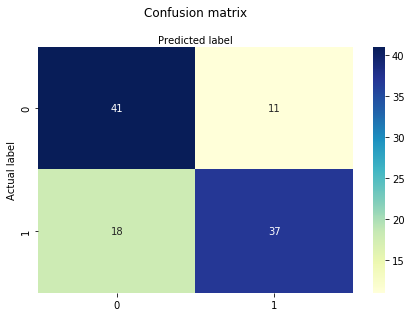

In [62]:
utils.display_confusion_matrix(y_test, y_pred)

In [63]:
prediction_probabilities = logreg.predict_proba(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("Log loss= ",log_loss(y_test, prediction_probabilities))

Accuracy: 0.7289719626168224
Precision: 0.7708333333333334
Recall: 0.6727272727272727
Log loss=  0.5400141349347515


In [64]:
scores = cross_val_score(logreg, X,y, cv=10, scoring='accuracy')
print(scores.mean())

0.745592108799656


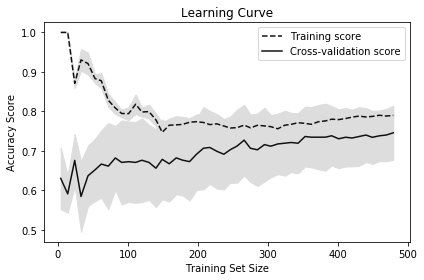

In [65]:
train_sizes, train_scores, test_scores = learning_curve(logreg, 
                                                        X, 
                                                        y,
                                                        # Number of folds in cross-validation
                                                        cv=10,
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 50))

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

#### Model Feature Optimization

In [68]:
X = feature_data_diff[feature_data_diff['season_t']>=2010]
X = X.drop(columns=['season_t'])
y = tourney_comp_ratings[tourney_comp_ratings['season_t']>=2010]['game_result']

model_stats = eliminate_features_logistic_regression(logreg, X,y)

Iteration=  0
least_important label=  upset_seed_threshold
Iteration=  1
least_important label=  delta_off_rebs_avg
Iteration=  2
least_important label=  delta_wol
Iteration=  3
least_important label=  delta_allow_off_rebs_avg
Iteration=  4
least_important label=  delta_fg_pct
Iteration=  5
least_important label=  delta_ft_pct
Iteration=  6
least_important label=  delta_rpi
Iteration=  7
least_important label=  delta_to_net_avg
Iteration=  8
least_important label=  delta_seed
Iteration=  9
least_important label=  delta_allow_ft_att_avg
Iteration=  10
least_important label=  delta_allow_def_rebs_avg
Iteration=  11
least_important label=  delta_ft_att_avg
Iteration=  12
least_important label=  delta_def_rebs_avg
Iteration=  13
least_important label=  delta_off_rating
Iteration=  14
least_important label=  top_conf
Iteration=  15
least_important label=  delta_mor
Iteration=  16
least_important label=  delta_sos
Iteration=  17
least_important label=  delta_wlk
Iteration=  18
least_importan

In [69]:
max_accuracy = 0
max_cross_val = 0
min_log_loss = 10000
for key, value in model_stats.items():
    accuracy = value['accuracy']
    cross_val = value['cross_validation']
    log_loss_val = value['log_loss']
    print('Accuracy= {0:6.4f} Cross Val= {1:6.4f}  Log Loss= {2:6.4f}'.format(accuracy ,cross_val, log_loss_val ))
    if accuracy > max_accuracy:
        max_accuracy = accuracy
        accuracy_hash = key
    if cross_val > max_cross_val:
        max_cross_val = cross_val
        cross_hash = key
    if log_loss_val < min_log_loss:
        min_log_loss = log_loss_val
        log_hash = key

print("\n")

print('Max Accuracy= {0:6.4f}'.format( model_stats[accuracy_hash]['accuracy']))
print('Max Cross Validation= {0:6.4f}'.format( model_stats[cross_hash]['cross_validation']))
print ("Minimum Log Loss= {0:6.4f}".format(  model_stats[log_hash]['log_loss']))
print('Log Loss at Max Accuracy= {0:6.4f}'.format( model_stats[accuracy_hash]['log_loss'] ))
print('Log Loss at Max Cross Validation= {0:6.4f} '.format( model_stats[cross_hash]['log_loss'] ))

Accuracy= 0.7290 Cross Val= 0.7456  Log Loss= 0.5400
Accuracy= 0.7290 Cross Val= 0.7513  Log Loss= 0.5400
Accuracy= 0.7290 Cross Val= 0.7549  Log Loss= 0.5396
Accuracy= 0.7477 Cross Val= 0.7419  Log Loss= 0.5424
Accuracy= 0.7570 Cross Val= 0.7438  Log Loss= 0.5400
Accuracy= 0.7570 Cross Val= 0.7400  Log Loss= 0.5400
Accuracy= 0.7570 Cross Val= 0.7438  Log Loss= 0.5398
Accuracy= 0.7664 Cross Val= 0.7512  Log Loss= 0.5378
Accuracy= 0.7290 Cross Val= 0.7494  Log Loss= 0.5437
Accuracy= 0.7009 Cross Val= 0.7476  Log Loss= 0.5591
Accuracy= 0.7383 Cross Val= 0.7458  Log Loss= 0.5592
Accuracy= 0.7290 Cross Val= 0.7418  Log Loss= 0.5644
Accuracy= 0.7290 Cross Val= 0.7457  Log Loss= 0.5581
Accuracy= 0.7009 Cross Val= 0.7458  Log Loss= 0.5671
Accuracy= 0.6822 Cross Val= 0.7515  Log Loss= 0.5644
Accuracy= 0.6729 Cross Val= 0.7366  Log Loss= 0.5763
Accuracy= 0.6916 Cross Val= 0.7328  Log Loss= 0.5714
Accuracy= 0.6916 Cross Val= 0.7327  Log Loss= 0.5743
Accuracy= 0.7009 Cross Val= 0.7308  Log Loss= 

In [70]:
labels = model_stats[cross_hash]['labels']
print(labels)

['top_conf', 'delta_margin_victory_avg', 'delta_fg_pct', 'delta_def_rebs_avg', 'delta_allow_def_rebs_avg', 'delta_ft_pct', 'delta_to_net_avg', 'delta_win_pct', 'delta_off_rating', 'delta_allow_off_rebs_avg', 'delta_ft_att_avg', 'delta_allow_ft_att_avg', 'delta_seed', 'delta_srs', 'delta_sos', 'delta_sag', 'delta_wlk', 'delta_wol', 'delta_rth', 'delta_col', 'delta_pom', 'delta_dol', 'delta_rpi', 'delta_mor']


In [71]:
X = feature_data_diff[feature_data_diff['season_t']>=2010][labels]

array([[41, 11],
       [18, 37]], dtype=int64)

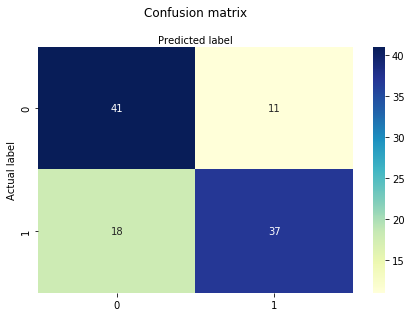

In [72]:
y = tourney_comp_ratings[tourney_comp_ratings['season_t']>=2010]['game_result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
# save model stats
prediction_probabilities = logreg.predict_proba(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
log_loss_value = log_loss(y_test, prediction_probabilities)
cross_val_scores = cross_val_score(logreg, X,y, cv=10, scoring='accuracy')
cross_validation_average = cross_val_scores.mean()

train_sizes, train_scores, test_scores = learning_curve(logreg, 
                                                        X, 
                                                        y,
                                                        # Number of folds in cross-validation
                                                        cv=10,
                                                        # Evaluation metric
                                                        scoring='accuracy',
                                                        # Use all computer cores
                                                        n_jobs=-1, 
                                                        # 50 different sizes of the training set
                                                        train_sizes=np.linspace(0.01, 1.0, 50))
utils.display_confusion_matrix(y_test, y_pred)



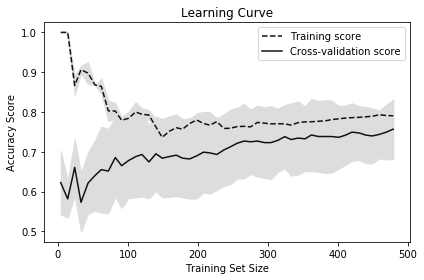

In [73]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of test set scores
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Draw lines
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")

# Draw bands
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

# Create plot
plt.title("Learning Curve")
plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

In [74]:
# Retrieve the non-normalized game stats
prediction_probabilities = logreg.predict_proba(X_test)
prediction_probabilities[:,1]
pred_probs = pd.Series(prediction_probabilities[:,1], index=X_test.index)
predictions = pd.Series(y_pred, index=y_test.index)
test_games = tourney_comp_ratings[tourney_comp_ratings.index.isin(X_test.index)].copy()

test_games[numeric_feature_to_scale] = scaler.inverse_transform(test_games[numeric_feature_to_scale])
test_games['predicted_result'] = predictions
test_games['pred_win_prob'] = pred_probs

test_games.head()

,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,game_result,start_season,Game Result,SRS_t,SOS_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,allow_fg_pct_t,ft_pct_t,allow_ft_att_avg_t,poss_avg_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,SRS_o,SOS_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,allow_fg_pct_o,ft_pct_o,allow_ft_att_avg_o,poss_avg_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,SAG_t,WLK_t,WOL_t,RTH_t,COL_t,POM_t,DOL_t,RPI_t,MOR_t,SAG_o,WLK_o,WOL_o,RTH_o,COL_o,POM_o,DOL_o,RPI_o,MOR_o,top_conf,upset_seed_threshold,predicted_result,pred_win_prob
7,2011,64,2011-03-18,11,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,6,Georgetown,8736b67f-5924-400b-bf94-3bd804c36600,1,2010,Win,8.56,3.78,0.700,71.0,66.0,0.434,0.424,0.715,18.0,75.240000,10.0,10.0,21.0,24.0,11.0,8.0,94.364700,20.0,2010,14.61,10.39,0.656,70.0,66.0,0.475,0.387,0.734,19.0,73.850000,10.0,10.0,23.0,19.0,13.0,6.0,94.786730,17.0,Atlantic 10,Big East,77.0,55.0,54,74.0,59.0,84.0,72.0,49.0,80.0,16.0,19.0,16,17.0,16.0,31.0,19.0,13.0,42.0,0,0,-1,0.461528
28,2012,64,2012-03-16,5,Temple,8598d1b6-106b-4083-a512-2e495729525a,12,South Florida,55af9c69-3675-4b9b-a882-96640b782fff,-1,2011,Lose,10.44,4.94,0.750,75.0,69.0,0.469,0.435,0.719,19.0,77.743750,10.0,11.0,21.0,22.0,12.0,7.0,96.470777,19.0,2011,9.20,7.29,0.611,59.0,56.0,0.437,0.386,0.705,16.0,69.133333,10.0,10.0,20.0,20.0,13.0,5.0,85.342334,16.0,American Athletic,American Athletic,36.0,29.0,28,35.0,22.0,34.0,20.0,20.0,42.0,70.0,51.0,60,53.0,59.0,66.0,60.0,52.0,47.0,0,1,-1,0.157553
34,2017,32,2017-03-19,11,Rhode Island,7e42bca2-3cd7-4aca-aa46-f190fe5d8eb4,3,Oregon,1da70895-f77f-44ef-b216-d63c02e696eb,-1,2016,Lose,12.88,4.62,0.714,73.0,65.0,0.454,0.406,0.668,24.0,77.840000,11.0,10.0,25.0,23.0,11.0,6.0,93.782117,22.0,2016,20.80,8.38,0.846,78.0,65.0,0.481,0.403,0.712,15.0,77.917949,10.0,10.0,26.0,22.0,11.0,6.0,100.105305,20.0,Atlantic 10,Pacific 12,48.0,40.0,48,53.0,43.0,37.0,52.0,31.0,31.0,13.0,14.0,8,11.0,7.0,16.0,12.0,9.0,24.0,-1,1,-1,0.122234
40,2013,68,2013-03-20,16,LIU Brooklyn,82c12e8d-7c6c-47d8-b100-3cbc190d268e,16,James Madison,524e3eec-7dde-45c7-b3cc-6308cec73350,-1,2012,Lose,-3.21,-5.80,0.588,78.0,76.0,0.479,0.468,0.691,19.0,80.676471,11.0,11.0,19.0,21.0,14.0,6.0,96.682464,25.0,2012,-1.73,-2.28,0.583,65.0,64.0,0.421,0.428,0.699,20.0,72.988889,10.0,10.0,19.0,24.0,11.0,7.0,89.054651,19.0,Northeast,Colonial,163.0,182.0,171,182.0,173.0,185.0,193.0,179.0,134.0,169.0,183.0,183,184.0,179.0,179.0,168.0,182.0,155.0,0,0,-1,0.196511
43,2017,64,2017-03-16,7,Saint Mary's,b18f34af-a7f1-4659-a2e5-fc11a31cd316,10,Virginia Commonwealth,c1c1e6df-a383-4fbd-ba7b-32d4f9ef9518,1,2016,Win,16.75,2.19,0.853,72.0,57.0,0.496,0.412,0.745,14.0,69.458824,9.0,7.0,25.0,19.0,10.0,4.0,103.658537,14.0,2016,11.57,3.77,0.743,74.0,66.0,0.461,0.422,0.705,22.0,79.537143,11.0,9.0,25.0,24.0,12.0,7.0,93.038293,21.0,West Coast,Atlantic 10,25.0,25.0,11,20.0,18.0,14.0,23.0,17.0,26.0,50.0,43.0,46,54.0,30.0,52.0,44.0,22.0,50.0,0,0,1,0.681363


In [75]:
missed_predictions = test_games[test_games['game_result'] != 
                                test_games['predicted_result']].sort_values(by='pred_win_prob', ascending=False)

print("Missed predictions= ", missed_predictions.shape[0])

missed_predictions

Missed predictions=  29


,season_t,round,game_date,seed_t,team_t,team_id_t,seed_o,team_o,team_id_o,game_result,start_season,Game Result,SRS_t,SOS_t,win_pct_t,pts_avg_t,opp_pts_avg_t,fg_pct_t,allow_fg_pct_t,ft_pct_t,allow_ft_att_avg_t,poss_avg_t,off_rebs_avg_t,allow_off_rebs_avg_t,def_rebs_avg_t,allow_def_rebs_avg_t,to_avg_t,steal_avg_t,off_rating_t,ft_att_avg_t,season_o,SRS_o,SOS_o,win_pct_o,pts_avg_o,opp_pts_avg_o,fg_pct_o,allow_fg_pct_o,ft_pct_o,allow_ft_att_avg_o,poss_avg_o,off_rebs_avg_o,allow_off_rebs_avg_o,def_rebs_avg_o,allow_def_rebs_avg_o,to_avg_o,steal_avg_o,off_rating_o,ft_att_avg_o,conf_name_t,conf_name_o,SAG_t,WLK_t,WOL_t,RTH_t,COL_t,POM_t,DOL_t,RPI_t,MOR_t,SAG_o,WLK_o,WOL_o,RTH_o,COL_o,POM_o,DOL_o,RPI_o,MOR_o,top_conf,upset_seed_threshold,predicted_result,pred_win_prob
358,2015,32,2015-03-21,1,Villanova,4383eb6a-7fd8-4ff2-94c5-43c933121e88,8,North Carolina State,52df1e19-b142-4a76-a439-ad68455d0581,-1,2014,Lose,23.13,7.55,0.917,76.0,60.0,0.470,0.406,0.731,16.0,73.861111,10.0,10.0,24.0,21.0,10.0,7.0,102.895826,22.0,2014,14.11,9.72,0.611,70.0,65.0,0.436,0.403,0.686,19.0,75.550000,12.0,11.0,25.0,23.0,10.0,3.0,92.653872,20.0,Big East,Atlantic Coast,6.0,4.0,2,2.0,2.0,5.0,2.0,2.0,4.0,32.0,33.0,40,32.0,40.0,38.0,40.0,39.0,22.0,-1,1,1,0.922386
488,2016,64,2016-03-18,3,West Virginia,f770d3a2-221c-49ce-9c7a-680f7417fe9e,14,Stephen F. Austin,5ef64f01-86ae-4553-9834-c79cc0859eaf,-1,2015,Lose,21.61,9.78,0.743,78.0,66.0,0.449,0.424,0.673,27.0,85.394286,15.0,8.0,23.0,22.0,14.0,9.0,91.341006,27.0,2015,9.23,-5.47,0.824,80.0,63.0,0.478,0.438,0.735,20.0,80.100000,11.0,9.0,23.0,22.0,12.0,9.0,99.875156,20.0,Big 12,Southland,6.0,6.0,8,8.0,11.0,6.0,7.0,10.0,11.0,57.0,55.0,62,101.0,83.0,33.0,80.0,62.0,36.0,1,1,1,0.886288
208,2010,16,2010-03-25,1,Syracuse,8cd24de1-2be8-4b77-bcfa-47be0495a5f4,5,Butler,bdb7d7a4-45f8-4bf3-ab85-15488c451494,-1,2009,Lose,21.72,7.21,0.857,80.0,66.0,0.516,0.398,0.677,15.0,81.457143,11.0,13.0,26.0,20.0,15.0,9.0,98.211154,21.0,2009,14.37,5.08,0.868,68.0,59.0,0.442,0.416,0.738,17.0,71.721053,9.0,8.0,23.0,21.0,12.0,7.0,94.811771,23.0,Atlantic Coast,Big East,3.0,4.0,3,2.0,3.0,5.0,4.0,5.0,6.0,22.0,15.0,13,23.0,11.0,26.0,12.0,12.0,24.0,1,0,1,0.773597
132,2015,4,2015-04-04,1,Kentucky,2267a1f4-68f6-418b-aaf6-2aa0c4b291f1,1,Wisconsin,c7569eae-5b93-4197-b204-6f3a62146b25,-1,2014,Lose,28.72,8.67,0.974,74.0,54.0,0.468,0.354,0.726,17.0,75.261538,12.0,11.0,25.0,19.0,10.0,6.0,98.323794,24.0,2014,24.61,10.29,0.900,72.0,58.0,0.479,0.428,0.763,11.0,67.925000,9.0,7.0,23.0,20.0,7.0,4.0,105.999264,19.0,Southeastern,Big Ten,1.0,1.0,1,1.0,1.0,1.0,1.0,1.0,2.0,2.0,3.0,5,3.0,3.0,3.0,4.0,4.0,3.0,0,0,1,0.753663
496,2017,32,2017-03-18,5,Iowa State,0e4258fa-3154-4c16-b693-adecab184c6c,4,Purdue,12d7f888-675b-459f-9099-a38f771d8a95,-1,2016,Lose,20.51,11.94,0.686,80.0,72.0,0.472,0.428,0.700,15.0,79.502857,9.0,11.0,25.0,26.0,10.0,7.0,100.625315,17.0,2016,20.13,8.79,0.771,79.0,68.0,0.479,0.421,0.757,14.0,79.171429,9.0,8.0,27.0,22.0,13.0,5.0,99.783472,19.0,Big 12,Big Ten,16.0,19.0,23,21.0,27.0,17.0,15.0,21.0,11.0,12.0,11.0,18,14.0,17.0,15.0,19.0,19.0,13.0,0,0,1,0.689740
52,2010,64,2010-03-19,12,Utah State,7672ff16-8436-47e6-8546-0fb5494ec7ee,5,Texas A&M,ef184799-d79b-49d9-a662-991eaf4044cd,-1,2009,Lose,13.62,1.23,0.771,73.0,59.0,0.488,0.405,0.758,15.0,71.874286,10.0,9.0,25.0,20.0,10.0,4.0,101.566227,16.0,2009,15.24,9.80,0.706,71.0,64.0,0.440,0.410,0.661,19.0,77.052941,11.0,10.0,25.0,23.0,12.0,6.0,92.144439,26.0,Mountain West,Southeastern,40.0,30.0,42,50.0,41.0,20.0,55.0,30.0,26.0,17.0,20.0,15,16.0,20.0,23.0,15.0,13.0,19.0,-1,1,1,0.615961
366,2012,64,2012-03-15,6,UNLV,68a3227f-677f-43b0-9a3a-cad79d0df9e2,11,Colorado,9fccbf28-2858-4263-821c-fdefb3c7efa3,-1,2011,Lose,13.55,4.37,0.743,76.0,65.0,0.457,0.410,0.676,19.0,80.617143,11.0,10.0,23.0,23.0,13.0,8.0,94.272753,20.0,2011,7.91,5.73,0.667,67.0,63.0,0.446,0.404,0.691,17.0,74.055556,9.0,10.0,23.0,22.0,13.0,5.0,90.472618,22.0,Mountain West,Pacific 12,24.0,34.0,27,27.0,27.0,33.0,26.0,18.0,37.0,80.0,81.0,76,63.0,64.0,75.0,63.0,6

In [76]:
result = missed_predictions[0:].apply(lambda x: utils.print_game_info(test_games, x['season_t'], x['round'], x['team_t']), axis=1)


                                    Villanova       North Carolina State     Stat Supports Winner
Allow FG %                      40.60                              40.30         True  (L)
Turnover Avg                    10.00                              10.00         True  (L)
SOS                              7.55                               9.72         True  (H)
Poss Avg                        73.86                              75.55         True  (H)
Off Rb Avg                      10.00                              12.00         True  (H)
Def Rb Avg                      24.00                              25.00         True  (H)
Seed                              1                                  8          False  (L)
SAG                              6.00                              32.00        False  (L)
WLK                              4.00                              33.00        False  (L)
WOL                              2.00                              40.00        Fal